In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
import sklearn

### EDA,  Data Preprocessing

In [2]:
data_raw = pd.read_csv('/Users/yul/Desktop/Github Fetch/LA_metro_bike_relocation/metro-bike-share-trip-data.csv')
data_raw = data_raw.dropna(axis=0, how='any')

/anaconda3/envs/yulenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Number of each passholder types
mask = data_raw[data_raw['Passholder Type'] == 'Staff Annual'].index
data_raw.drop(mask,inplace=True)
data_raw['Passholder Type'].value_counts()

Monthly Pass    60093
Walk-up         30532
Flex Pass        7200
Name: Passholder Type, dtype: int64

In [4]:
# Delete Round-Trip categories.
mask = data_raw[data_raw['Trip Route Category'] == 'Round Trip'].index
data_raw.drop(mask,inplace=True)
data_raw['Trip Route Category'].value_counts()

One Way    88266
Name: Trip Route Category, dtype: int64

In [5]:
# Replace passholder types to walk-up(0) and passes (1)
ndata = data_raw.copy()
temp = {'Walk-up':0,'Monthly Pass':1,'Flex Pass':1}
ndata = ndata.replace(temp)
ndata['Passholder Type'].value_counts()

1    64025
0    24241
Name: Passholder Type, dtype: int64

In [6]:
ndata['Distance'] = ndata.apply(
    (lambda row: geopy.distance.distance(
        (row['Starting Station Latitude'], row['Starting Station Longitude']),
        (row['Ending Station Latitude'], row['Ending Station Longitude'])).miles), axis=1)
ndata = ndata.drop(['Trip ID', 'Starting Station Latitude','Starting Station Longitude',
                   'Ending Station Latitude','Ending Station Longitude',
                    'Starting Lat-Long', 'Ending Lat-Long'
                   ,'Plan Duration','End Time','Trip Route Category','Bike ID'], axis=1)
ndata.iloc[:15, :]

,Duration,Start Time,Starting Station ID,Ending Station ID,Passholder Type,Distance
5,780,2016-07-07T12:51:00,3021.0,3054.0,1,0.441488
6,600,2016-07-07T12:54:00,3022.0,3014.0,1,0.763951
7,600,2016-07-07T12:59:00,3076.0,3005.0,1,0.624177
9,960,2016-07-07T13:01:00,3031.0,3078.0,1,1.556036
10,960,2016-07-07T13:02:00,3031.0,3047.0,1,0.864494
11,720,2016-07-07T13:03:00,3063.0,3005.0,1,0.359644
12,360,2016-07-07T13:03:00,3042.0,3030.0,1,0.326241
14,660,2016-07-07T13:04:00,3054.0,3030.0,1,0.965416
15,480,2016-07-07T13:04:00,3031.0,3076.0,1,0.293838
16,2100,2016-07-07T13:06:00,3006.0,3033.0,1,0.317622


In [7]:
ndata['Start Time'] = pd.to_datetime(ndata['Start Time'])
ndata.dtypes

Duration                        int64
Start Time             datetime64[ns]
Starting Station ID           float64
Ending Station ID             float64
Passholder Type                 int64
Distance                      float64
dtype: object

In [8]:
temp = pd.crosstab(ndata['Starting Station ID'],ndata['Ending Station ID']) # Most popular trip
temp.stack().index[np.argmax(temp.values)]

(3030.0, 3014.0)

In [9]:
temp.iloc[10:15,:70] # The most popular trip counts

Ending Station ID,3005.0,3006.0,3007.0,3008.0,3010.0,3011.0,3014.0,3016.0,3018.0,3019.0,...,3074.0,3075.0,3076.0,3077.0,3078.0,3079.0,3080.0,3081.0,3082.0,4108.0
Starting Station ID,,,,,,,,,,,,,,,,,,,,,
3020.0,13,12,2,1,2,2,11,0,2,19,...,11,13,6,2,1,0,1,1,3,0
3021.0,42,22,10,6,1,0,69,28,8,5,...,33,8,13,3,5,8,0,2,0,0
3022.0,87,24,58,13,1,1,111,20,3,1,...,8,60,15,10,8,12,0,29,117,1
3023.0,37,20,17,14,1,11,113,128,13,7,...,11,4,22,1,37,6,1,0,45,0
3024.0,49,10,42,12,0,16,41,55,6,5,...,4,4,1,0,5,8,0,1,12,0


### Check : What criteria customers are choosing Passes

In [10]:
# Assume passengers are following the average duration minutes for each pass.
ndata['Duration_min'] = np.floor(ndata['Duration']/60)
print(ndata[['Passholder Type','Duration', 'Duration_min', 'Distance']].groupby('Passholder Type').mean())

                    Duration  Duration_min  Distance
Passholder Type                                     
0                2166.942783     36.115713  1.431571
1                 771.725107     12.862085  5.347379


In [11]:
print(ndata[['Passholder Type','Duration', 'Duration_min', 'Distance']].groupby('Passholder Type').median())

                 Duration  Duration_min  Distance
Passholder Type                                  
0                     960          16.0  0.730822
1                     480           8.0  0.612904


In [12]:
# Probability of taking a ride a day for each Pass
prob_annual = 150/1.75/365
prob_month = 17/1.75/30
prob_daily = 1
print("Annual prob. is %.2f, monthly prob. is %.2f, daily prob. is %.2f"%(prob_annual,prob_month,prob_daily))

# Minimum Utility for buying each Pass a day
util_annual = (1.75*np.ceil(150/1.75))/365
util_month = (1.75*np.ceil(17/1.75))/30
util_daily = 1.75*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

print(prob_annual*150)

Annual prob. is 0.23, monthly prob. is 0.32, daily prob. is 1.00
Annual utility is 0.41, monthly utility is 0.58
35.22504892367906


### Count the total demand and supply for each stations

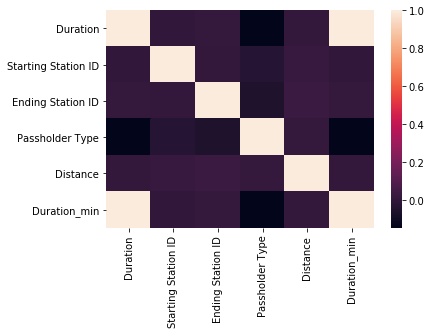

In [13]:
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le1.fit(ndata['Starting Station ID'])
ndata['Starting Station ID'] = le1.transform(ndata['Starting Station ID'])
keys1 = le1.classes_
values1 = le1.transform(le1.classes_)
dictionary1 = dict(zip(keys1, values1))

le2 = preprocessing.LabelEncoder()
le2.fit(ndata['Ending Station ID'])
ndata['Ending Station ID'] = le2.transform(ndata['Ending Station ID'])
keys2 = le2.classes_
values2 = le2.transform(le2.classes_)
dictionary2 = dict(zip(keys2, values2))

import seaborn as sns
sns.heatmap(ndata.corr())

In [14]:
# Demand for bikes at each station
d_data = ndata[['Passholder Type','Starting Station ID']].groupby('Starting Station ID').count()
d_data = d_data.rename(columns={'Starting Station ID':'ID','Passholder Type':'D'})

# Supply for bikes at each station
s_data = ndata[['Passholder Type','Ending Station ID']].groupby('Ending Station ID').count()
s_data = s_data.rename(columns={'Endinf Station ID':'ID','Passholder Type':'S'})

In [15]:
# Net Supply stations
# s_data.rename(columns={'Starting Station ID':'ID'})
s_data['D'] = d_data['D']
s_data.head(3)

def calculate_nets(row):
    temp = np.maximum(row['S'] - row['D'],0)
    return temp

s_data['Net'] = s_data.apply(calculate_nets, axis=1)
s_data = s_data.drop(['D'],axis=1)
s_data.head(5)

,S,Net
Ending Station ID,,
0,4371,1012
1,2086,143
2,1334,0
3,1539,107
4,241,0


In [16]:
# Net Demand stations
# s_data.rename(columns={'Starting Station ID':'ID'})
d_data['S'] = s_data['S']
d_data.head(3)

def calculate_nets2(row):
    temp2 = np.maximum(row['D'] - row['S'],0)
    return temp2

d_data['Net'] = d_data.apply(calculate_nets2, axis=1)
d_data = d_data.drop(['S', 'D'],axis=1)
s_data = s_data.drop(['S'],axis=1)
s_data = s_data[s_data.values.sum(axis=1) != 0]
d_data = d_data[d_data.values.sum(axis=1) != 0]
d_data.head(5)

,Net
Starting Station ID,
2,488
4,39
7,21
14,731
16,230


In [23]:
# For formulation
s_data_constraint = s_data.T.to_dict('records')
d_data_constraint = d_data.T.to_dict('records')

In [24]:
print(len(s_data), len(d_data))

37 27


In [25]:
s_data_constraint = str(s_data_constraint[0])
d_data_constraint = str(d_data_constraint[0])
d_data_constraint
import ast
s_data_constraint = ast.literal_eval(s_data_constraint)
d_data_constraint = ast.literal_eval(d_data_constraint)

In [27]:
price_matrix = ndata[['Ending Station ID','Starting Station ID','Duration', 'Duration_min', 'Distance']].groupby(['Ending Station ID','Starting Station ID'],as_index=False).mean()
price_matrix['Price'] = 1.75 * (np.floor(price_matrix['Duration_min']/30)+1)
price_matrix

,Ending Station ID,Starting Station ID,Duration,Duration_min,Distance,Price
0,0,1,525.974026,8.766234,0.248361,1.75
1,0,2,1255.636364,20.927273,0.288265,1.75
2,0,3,1032.000000,17.200000,0.249927,1.75
3,0,4,1710.000000,28.500000,0.828233,1.75
4,0,5,2896.800000,48.280000,0.724004,3.50
5,0,6,1490.958904,24.849315,1.370474,1.75
6,0,7,857.142857,14.285714,1.047197,1.75
7,0,8,2394.545455,39.909091,0.337920,3.50
8,0,9,1077.647059,17.960784,0.693005,1.75
9,0,10,1167.692308,19.461538,1.291276,1.75


In [28]:
price_matrix = price_matrix[(price_matrix['Ending Station ID'].isin(s_data_constraint))&
             (price_matrix['Starting Station ID'].isin(d_data_constraint))]
# price_matrix.to_csv('price_matrix.csv', encoding='utf-8', index=False)

In [29]:
price_constraint = price_matrix[(price_matrix['Ending Station ID'].isin(s_data_constraint))&
             (price_matrix['Starting Station ID'].isin(d_data_constraint))]
price_constraint['key']='('+price_constraint['Ending Station ID'].astype(str)+' , '+price_constraint['Starting Station ID'].astype(str)+')'
price_constraint = price_constraint.drop(['Duration','Duration_min','Distance','Starting Station ID','Ending Station ID'],axis=1)
price_constraint.set_index('key',inplace=True)
price_constraint = price_constraint.T.to_dict('records')
# price_constraint = str(price_constraint)
price_constraint = price_constraint[0]
price_constraint

{'(0 , 2)': 1.75,
 '(0 , 4)': 1.75,
 '(0 , 7)': 1.75,
 '(0 , 14)': 1.75,
 '(0 , 16)': 1.75,
 '(0 , 17)': 1.75,
 '(0 , 18)': 1.75,
 '(0 , 19)': 1.75,
 '(0 , 20)': 1.75,
 '(0 , 28)': 1.75,
 '(0 , 29)': 3.5,
 '(0 , 32)': 1.75,
 '(0 , 33)': 1.75,
 '(0 , 35)': 1.75,
 '(0 , 36)': 1.75,
 '(0 , 37)': 1.75,
 '(0 , 38)': 1.75,
 '(0 , 39)': 3.5,
 '(0 , 40)': 1.75,
 '(0 , 44)': 1.75,
 '(0 , 46)': 1.75,
 '(0 , 50)': 1.75,
 '(0 , 51)': 1.75,
 '(0 , 52)': 1.75,
 '(0 , 53)': 1.75,
 '(0 , 57)': 1.75,
 '(0 , 60)': 3.5,
 '(1 , 2)': 1.75,
 '(1 , 4)': 1.75,
 '(1 , 7)': 1.75,
 '(1 , 14)': 1.75,
 '(1 , 16)': 3.5,
 '(1 , 17)': 1.75,
 '(1 , 18)': 7.0,
 '(1 , 19)': 1.75,
 '(1 , 20)': 1.75,
 '(1 , 28)': 1.75,
 '(1 , 29)': 1.75,
 '(1 , 32)': 7.0,
 '(1 , 33)': 1.75,
 '(1 , 35)': 1.75,
 '(1 , 36)': 1.75,
 '(1 , 37)': 1.75,
 '(1 , 38)': 3.5,
 '(1 , 39)': 1.75,
 '(1 , 40)': 1.75,
 '(1 , 44)': 1.75,
 '(1 , 46)': 1.75,
 '(1 , 50)': 1.75,
 '(1 , 51)': 1.75,
 '(1 , 52)': 1.75,
 '(1 , 53)': 1.75,
 '(1 , 57)': 1.75,
 '(3 ,

In [30]:
price_constraint = {(0 , 2): 1.75,
  (0 , 4): 1.75,
  (0 , 7): 1.75,
  (0 , 14): 1.75,
  (0 , 16): 1.75,
  (0 , 17): 1.75,
  (0 , 18): 1.75,
  (0 , 19): 1.75,
  (0 , 20): 1.75,
  (0 , 28): 1.75,
  (0 , 29): 3.5,
  (0 , 32): 1.75,
  (0 , 33): 1.75,
  (0 , 35): 1.75,
  (0 , 36): 1.75,
  (0 , 37): 1.75,
  (0 , 38): 1.75,
  (0 , 39): 3.5,
  (0 , 40): 1.75,
  (0 , 44): 1.75,
  (0 , 46): 1.75,
  (0 , 50): 1.75,
  (0 , 51): 1.75,
  (0 , 52): 1.75,
  (0 , 53): 1.75,
  (0 , 57): 1.75,
  (0 , 60): 3.5,
  (1 , 2): 1.75,
  (1 , 4): 1.75,
  (1 , 7): 1.75,
  (1 , 14): 1.75,
  (1 , 16): 3.5,
  (1 , 17): 1.75,
  (1 , 18): 7.0,
  (1 , 19): 1.75,
  (1 , 20): 1.75,
  (1 , 28): 1.75,
  (1 , 29): 1.75,
  (1 , 32): 7.0,
  (1 , 33): 1.75,
  (1 , 35): 1.75,
  (1 , 36): 1.75,
  (1 , 37): 1.75,
  (1 , 38): 3.5,
  (1 , 39): 1.75,
  (1 , 40): 1.75,
  (1 , 44): 1.75,
  (1 , 46): 1.75,
  (1 , 50): 1.75,
  (1 , 51): 1.75,
  (1 , 52): 1.75,
  (1 , 53): 1.75,
  (1 , 57): 1.75,
  (3 , 2): 1.75,
  (3 , 4): 1.75,
  (3 , 14): 1.75,
  (3 , 16): 1.75,
  (3 , 17): 1.75,
  (3 , 18): 1.75,
  (3 , 19): 1.75,
  (3 , 20): 1.75,
  (3 , 28): 1.75,
  (3 , 29): 3.5,
  (3 , 32): 1.75,
  (3 , 33): 1.75,
  (3 , 35): 1.75,
  (3 , 36): 1.75,
  (3 , 37): 1.75,
  (3 , 40): 1.75,
  (3 , 44): 1.75,
  (3 , 46): 7.0,
  (3 , 50): 3.5,
  (3 , 51): 1.75,
  (3 , 52): 1.75,
  (3 , 53): 1.75,
  (3 , 57): 1.75,
  (5 , 2): 1.75,
  (5 , 4): 1.75,
  (5 , 7): 1.75,
  (5 , 14): 1.75,
  (5 , 16): 1.75,
  (5 , 17): 1.75,
  (5 , 18): 1.75,
  (5 , 19): 1.75,
  (5 , 20): 3.5,
  (5 , 28): 1.75,
  (5 , 29): 1.75,
  (5 , 32): 1.75,
  (5 , 33): 1.75,
  (5 , 35): 1.75,
  (5 , 36): 1.75,
  (5 , 37): 3.5,
  (5 , 40): 1.75,
  (5 , 44): 1.75,
  (5 , 46): 3.5,
  (5 , 51): 3.5,
  (5 , 52): 1.75,
  (5 , 53): 1.75,
  (5 , 60): 1.75,
  (6 , 2): 3.5,
  (6 , 4): 1.75,
  (6 , 7): 1.75,
  (6 , 14): 1.75,
  (6 , 16): 1.75,
  (6 , 17): 1.75,
  (6 , 18): 1.75,
  (6 , 19): 3.5,
  (6 , 20): 1.75,
  (6 , 28): 1.75,
  (6 , 29): 1.75,
  (6 , 32): 1.75,
  (6 , 33): 12.25,
  (6 , 35): 1.75,
  (6 , 36): 5.25,
  (6 , 37): 3.5,
  (6 , 39): 1.75,
  (6 , 40): 1.75,
  (6 , 44): 3.5,
  (6 , 46): 1.75,
  (6 , 50): 1.75,
  (6 , 51): 1.75,
  (6 , 52): 1.75,
  (6 , 53): 1.75,
  (6 , 57): 1.75,
  (6 , 60): 1.75,
  (8 , 2): 1.75,
  (8 , 4): 1.75,
  (8 , 7): 1.75,
  (8 , 14): 1.75,
  (8 , 16): 1.75,
  (8 , 17): 1.75,
  (8 , 18): 1.75,
  (8 , 19): 1.75,
  (8 , 20): 1.75,
  (8 , 28): 1.75,
  (8 , 29): 1.75,
  (8 , 33): 1.75,
  (8 , 35): 1.75,
  (8 , 36): 1.75,
  (8 , 37): 1.75,
  (8 , 40): 1.75,
  (8 , 44): 1.75,
  (8 , 46): 1.75,
  (8 , 50): 1.75,
  (8 , 51): 7.0,
  (8 , 52): 3.5,
  (8 , 53): 1.75,
  (8 , 57): 1.75,
  (8 , 60): 1.75,
  (9 , 2): 1.75,
  (9 , 4): 1.75,
  (9 , 7): 1.75,
  (9 , 14): 15.75,
  (9 , 16): 7.0,
  (9 , 17): 1.75,
  (9 , 18): 17.5,
  (9 , 19): 1.75,
  (9 , 20): 1.75,
  (9 , 28): 1.75,
  (9 , 32): 1.75,
  (9 , 33): 1.75,
  (9 , 35): 1.75,
  (9 , 36): 1.75,
  (9 , 37): 1.75,
  (9 , 39): 1.75,
  (9 , 40): 1.75,
  (9 , 44): 1.75,
  (9 , 46): 1.75,
  (9 , 50): 1.75,
  (9 , 51): 1.75,
  (9 , 52): 1.75,
  (9 , 53): 1.75,
  (9 , 57): 1.75,
  (9 , 60): 1.75,
  (10 , 4): 1.75,
  (10 , 7): 1.75,
  (10 , 17): 7.0,
  (10 , 19): 1.75,
  (10 , 28): 1.75,
  (10 , 33): 1.75,
  (10 , 36): 1.75,
  (10 , 37): 1.75,
  (10 , 39): 1.75,
  (10 , 40): 3.5,
  (10 , 51): 1.75,
  (10 , 53): 3.5,
  (10 , 57): 1.75,
  (10 , 60): 1.75,
  (11 , 2): 3.5,
  (11 , 7): 1.75,
  (11 , 14): 1.75,
  (11 , 16): 1.75,
  (11 , 17): 1.75,
  (11 , 18): 1.75,
  (11 , 19): 3.5,
  (11 , 20): 1.75,
  (11 , 28): 1.75,
  (11 , 29): 3.5,
  (11 , 32): 1.75,
  (11 , 33): 1.75,
  (11 , 35): 1.75,
  (11 , 36): 1.75,
  (11 , 37): 1.75,
  (11 , 39): 3.5,
  (11 , 40): 1.75,
  (11 , 44): 1.75,
  (11 , 46): 1.75,
  (11 , 50): 1.75,
  (11 , 51): 1.75,
  (11 , 52): 1.75,
  (11 , 53): 1.75,
  (11 , 57): 1.75,
  (12 , 2): 1.75,
  (12 , 7): 1.75,
  (12 , 14): 1.75,
  (12 , 16): 1.75,
  (12 , 17): 1.75,
  (12 , 18): 1.75,
  (12 , 19): 1.75,
  (12 , 20): 1.75,
  (12 , 28): 1.75,
  (12 , 29): 3.5,
  (12 , 32): 1.75,
  (12 , 33): 3.5,
  (12 , 35): 1.75,
  (12 , 36): 3.5,
  (12 , 37): 3.5,
  (12 , 39): 1.75,
  (12 , 40): 1.75,
  (12 , 44): 1.75,
  (12 , 46): 1.75,
  (12 , 50): 1.75,
  (12 , 51): 1.75,
  (12 , 52): 1.75,
  (12 , 53): 1.75,
  (12 , 57): 1.75,
  (13 , 2): 1.75,
  (13 , 4): 1.75,
  (13 , 7): 1.75,
  (13 , 14): 1.75,
  (13 , 16): 1.75,
  (13 , 17): 3.5,
  (13 , 18): 1.75,
  (13 , 19): 1.75,
  (13 , 20): 1.75,
  (13 , 28): 1.75,
  (13 , 29): 1.75,
  (13 , 32): 1.75,
  (13 , 33): 3.5,
  (13 , 35): 1.75,
  (13 , 36): 1.75,
  (13 , 37): 1.75,
  (13 , 39): 1.75,
  (13 , 40): 1.75,
  (13 , 44): 1.75,
  (13 , 46): 1.75,
  (13 , 50): 1.75,
  (13 , 51): 1.75,
  (13 , 52): 1.75,
  (13 , 53): 3.5,
  (13 , 57): 1.75,
  (15 , 2): 3.5,
  (15 , 4): 1.75,
  (15 , 17): 7.0,
  (15 , 18): 1.75,
  (15 , 20): 8.75,
  (15 , 28): 3.5,
  (15 , 29): 1.75,
  (15 , 32): 1.75,
  (15 , 33): 3.5,
  (15 , 36): 3.5,
  (15 , 37): 3.5,
  (15 , 40): 7.0,
  (15 , 44): 1.75,
  (15 , 46): 1.75,
  (15 , 50): 3.5,
  (15 , 51): 3.5,
  (15 , 52): 1.75,
  (15 , 53): 1.75,
  (15 , 57): 1.75,
  (15 , 60): 1.75,
  (21 , 2): 1.75,
  (21 , 4): 1.75,
  (21 , 7): 1.75,
  (21 , 14): 3.5,
  (21 , 16): 1.75,
  (21 , 17): 1.75,
  (21 , 18): 1.75,
  (21 , 19): 1.75,
  (21 , 20): 1.75,
  (21 , 28): 3.5,
  (21 , 29): 1.75,
  (21 , 32): 1.75,
  (21 , 33): 7.0,
  (21 , 35): 1.75,
  (21 , 36): 3.5,
  (21 , 37): 1.75,
  (21 , 39): 1.75,
  (21 , 40): 5.25,
  (21 , 44): 1.75,
  (21 , 46): 1.75,
  (21 , 50): 1.75,
  (21 , 51): 3.5,
  (21 , 52): 1.75,
  (21 , 53): 1.75,
  (21 , 57): 1.75,
  (21 , 60): 1.75,
  (22 , 2): 5.25,
  (22 , 4): 1.75,
  (22 , 7): 3.5,
  (22 , 14): 1.75,
  (22 , 16): 1.75,
  (22 , 17): 1.75,
  (22 , 18): 1.75,
  (22 , 19): 1.75,
  (22 , 20): 1.75,
  (22 , 28): 1.75,
  (22 , 29): 5.25,
  (22 , 32): 3.5,
  (22 , 33): 1.75,
  (22 , 35): 1.75,
  (22 , 36): 1.75,
  (22 , 37): 1.75,
  (22 , 38): 1.75,
  (22 , 39): 1.75,
  (22 , 40): 1.75,
  (22 , 44): 1.75,
  (22 , 46): 1.75,
  (22 , 50): 1.75,
  (22 , 51): 1.75,
  (22 , 52): 1.75,
  (22 , 53): 1.75,
  (22 , 57): 1.75,
  (23 , 2): 3.5,
  (23 , 4): 1.75,
  (23 , 7): 3.5,
  (23 , 14): 1.75,
  (23 , 16): 1.75,
  (23 , 17): 1.75,
  (23 , 18): 1.75,
  (23 , 19): 1.75,
  (23 , 20): 1.75,
  (23 , 28): 3.5,
  (23 , 29): 1.75,
  (23 , 33): 1.75,
  (23 , 35): 1.75,
  (23 , 36): 1.75,
  (23 , 40): 3.5,
  (23 , 44): 1.75,
  (23 , 46): 1.75,
  (23 , 51): 1.75,
  (23 , 52): 1.75,
  (23 , 53): 1.75,
  (23 , 57): 1.75,
  (23 , 60): 1.75,
  (24 , 2): 1.75,
  (24 , 4): 7.0,
  (24 , 7): 1.75,
  (24 , 14): 1.75,
  (24 , 16): 1.75,
  (24 , 17): 1.75,
  (24 , 18): 1.75,
  (24 , 19): 1.75,
  (24 , 20): 1.75,
  (24 , 28): 3.5,
  (24 , 29): 1.75,
  (24 , 32): 15.75,
  (24 , 33): 1.75,
  (24 , 35): 1.75,
  (24 , 36): 1.75,
  (24 , 37): 1.75,
  (24 , 39): 3.5,
  (24 , 40): 1.75,
  (24 , 44): 1.75,
  (24 , 46): 1.75,
  (24 , 50): 5.25,
  (24 , 51): 3.5,
  (24 , 52): 1.75,
  (24 , 53): 1.75,
  (24 , 57): 1.75,
  (25 , 2): 1.75,
  (25 , 4): 1.75,
  (25 , 7): 3.5,
  (25 , 14): 1.75,
  (25 , 16): 1.75,
  (25 , 17): 1.75,
  (25 , 18): 3.5,
  (25 , 19): 1.75,
  (25 , 20): 1.75,
  (25 , 28): 1.75,
  (25 , 29): 3.5,
  (25 , 32): 1.75,
  (25 , 33): 1.75,
  (25 , 35): 1.75,
  (25 , 36): 1.75,
  (25 , 37): 3.5,
  (25 , 39): 3.5,
  (25 , 40): 1.75,
  (25 , 44): 1.75,
  (25 , 46): 1.75,
  (25 , 50): 3.5,
  (25 , 51): 1.75,
  (25 , 52): 1.75,
  (25 , 53): 1.75,
  (25 , 57): 1.75,
  (25 , 60): 1.75,
  (26 , 2): 3.5,
  (26 , 7): 1.75,
  (26 , 14): 1.75,
  (26 , 17): 1.75,
  (26 , 19): 1.75,
  (26 , 20): 1.75,
  (26 , 28): 3.5,
  (26 , 29): 1.75,
  (26 , 32): 3.5,
  (26 , 33): 1.75,
  (26 , 35): 1.75,
  (26 , 36): 5.25,
  (26 , 37): 1.75,
  (26 , 39): 1.75,
  (26 , 40): 5.25,
  (26 , 46): 1.75,
  (26 , 50): 1.75,
  (26 , 51): 1.75,
  (26 , 52): 1.75,
  (26 , 53): 1.75,
  (26 , 57): 1.75,
  (26 , 60): 1.75,
  (27 , 2): 1.75,
  (27 , 4): 1.75,
  (27 , 7): 1.75,
  (27 , 14): 1.75,
  (27 , 16): 3.5,
  (27 , 17): 1.75,
  (27 , 18): 1.75,
  (27 , 19): 1.75,
  (27 , 20): 3.5,
  (27 , 28): 1.75,
  (27 , 29): 1.75,
  (27 , 32): 1.75,
  (27 , 33): 1.75,
  (27 , 35): 1.75,
  (27 , 36): 1.75,
  (27 , 37): 1.75,
  (27 , 39): 1.75,
  (27 , 40): 1.75,
  (27 , 46): 1.75,
  (27 , 50): 1.75,
  (27 , 51): 3.5,
  (27 , 52): 1.75,
  (27 , 53): 1.75,
  (27 , 57): 1.75,
  (30 , 2): 3.5,
  (30 , 4): 1.75,
  (30 , 7): 1.75,
  (30 , 14): 1.75,
  (30 , 16): 1.75,
  (30 , 17): 1.75,
  (30 , 18): 1.75,
  (30 , 19): 1.75,
  (30 , 20): 1.75,
  (30 , 28): 1.75,
  (30 , 29): 3.5,
  (30 , 32): 1.75,
  (30 , 33): 1.75,
  (30 , 35): 1.75,
  (30 , 36): 1.75,
  (30 , 37): 1.75,
  (30 , 39): 1.75,
  (30 , 40): 1.75,
  (30 , 44): 3.5,
  (30 , 46): 5.25,
  (30 , 50): 5.25,
  (30 , 51): 1.75,
  (30 , 52): 1.75,
  (30 , 53): 1.75,
  (30 , 57): 1.75,
  (30 , 60): 1.75,
  (31 , 2): 3.5,
  (31 , 4): 1.75,
  (31 , 7): 1.75,
  (31 , 14): 1.75,
  (31 , 20): 3.5,
  (31 , 28): 3.5,
  (31 , 29): 3.5,
  (31 , 33): 1.75,
  (31 , 36): 8.75,
  (31 , 39): 1.75,
  (31 , 40): 3.5,
  (31 , 44): 3.5,
  (31 , 46): 1.75,
  (31 , 51): 1.75,
  (31 , 57): 1.75,
  (31 , 60): 1.75,
  (34 , 2): 1.75,
  (34 , 7): 1.75,
  (34 , 14): 1.75,
  (34 , 16): 3.5,
  (34 , 17): 5.25,
  (34 , 18): 1.75,
  (34 , 19): 1.75,
  (34 , 20): 3.5,
  (34 , 28): 1.75,
  (34 , 29): 1.75,
  (34 , 32): 1.75,
  (34 , 33): 1.75,
  (34 , 35): 1.75,
  (34 , 36): 1.75,
  (34 , 37): 1.75,
  (34 , 39): 7.0,
  (34 , 40): 1.75,
  (34 , 44): 3.5,
  (34 , 46): 1.75,
  (34 , 50): 1.75,
  (34 , 51): 1.75,
  (34 , 52): 1.75,
  (34 , 53): 1.75,
  (34 , 57): 1.75,
  (34 , 60): 1.75,
  (41 , 2): 1.75,
  (41 , 4): 1.75,
  (41 , 14): 1.75,
  (41 , 16): 1.75,
  (41 , 17): 1.75,
  (41 , 18): 1.75,
  (41 , 19): 1.75,
  (41 , 20): 1.75,
  (41 , 28): 1.75,
  (41 , 29): 1.75,
  (41 , 33): 1.75,
  (41 , 35): 3.5,
  (41 , 36): 1.75,
  (41 , 37): 1.75,
  (41 , 38): 1.75,
  (41 , 44): 1.75,
  (41 , 46): 1.75,
  (41 , 50): 1.75,
  (41 , 51): 29.75,
  (41 , 52): 1.75,
  (41 , 53): 1.75,
  (41 , 57): 1.75,
  (42 , 2): 3.5,
  (42 , 4): 1.75,
  (42 , 14): 10.5,
  (42 , 17): 1.75,
  (42 , 18): 1.75,
  (42 , 20): 1.75,
  (42 , 28): 1.75,
  (42 , 29): 5.25,
  (42 , 32): 1.75,
  (42 , 33): 3.5,
  (42 , 35): 1.75,
  (42 , 36): 1.75,
  (42 , 37): 1.75,
  (42 , 40): 1.75,
  (42 , 44): 3.5,
  (42 , 50): 3.5,
  (42 , 51): 1.75,
  (42 , 52): 1.75,
  (42 , 53): 1.75,
  (43 , 2): 12.25,
  (43 , 7): 5.25,
  (43 , 14): 1.75,
  (43 , 16): 1.75,
  (43 , 17): 1.75,
  (43 , 18): 1.75,
  (43 , 19): 1.75,
  (43 , 20): 1.75,
  (43 , 28): 1.75,
  (43 , 29): 29.75,
  (43 , 32): 1.75,
  (43 , 33): 1.75,
  (43 , 35): 3.5,
  (43 , 36): 5.25,
  (43 , 37): 1.75,
  (43 , 39): 1.75,
  (43 , 40): 1.75,
  (43 , 46): 1.75,
  (43 , 50): 1.75,
  (43 , 51): 1.75,
  (43 , 52): 5.25,
  (43 , 53): 1.75,
  (43 , 57): 1.75,
  (45 , 2): 1.75,
  (45 , 4): 3.5,
  (45 , 7): 3.5,
  (45 , 17): 1.75,
  (45 , 28): 1.75,
  (45 , 29): 1.75,
  (45 , 33): 1.75,
  (45 , 36): 1.75,
  (45 , 37): 1.75,
  (45 , 38): 1.75,
  (45 , 40): 1.75,
  (45 , 44): 3.5,
  (45 , 46): 1.75,
  (45 , 51): 1.75,
  (45 , 52): 1.75,
  (45 , 53): 1.75,
  (45 , 60): 1.75,
  (47 , 2): 1.75,
  (47 , 4): 1.75,
  (47 , 7): 1.75,
  (47 , 14): 1.75,
  (47 , 16): 1.75,
  (47 , 17): 1.75,
  (47 , 18): 3.5,
  (47 , 19): 1.75,
  (47 , 20): 1.75,
  (47 , 28): 5.25,
  (47 , 29): 1.75,
  (47 , 32): 1.75,
  (47 , 33): 1.75,
  (47 , 35): 1.75,
  (47 , 36): 1.75,
  (47 , 37): 1.75,
  (47 , 38): 1.75,
  (47 , 39): 1.75,
  (47 , 40): 1.75,
  (47 , 44): 1.75,
  (47 , 46): 1.75,
  (47 , 50): 1.75,
  (47 , 51): 1.75,
  (47 , 52): 1.75,
  (47 , 53): 3.5,
  (47 , 57): 1.75,
  (47 , 60): 1.75,
  (48 , 2): 1.75,
  (48 , 4): 1.75,
  (48 , 7): 1.75,
  (48 , 14): 1.75,
  (48 , 16): 1.75,
  (48 , 17): 1.75,
  (48 , 18): 1.75,
  (48 , 19): 1.75,
  (48 , 20): 3.5,
  (48 , 28): 1.75,
  (48 , 29): 1.75,
  (48 , 32): 1.75,
  (48 , 33): 1.75,
  (48 , 35): 1.75,
  (48 , 36): 1.75,
  (48 , 37): 1.75,
  (48 , 39): 1.75,
  (48 , 40): 1.75,
  (48 , 44): 1.75,
  (48 , 46): 1.75,
  (48 , 50): 1.75,
  (48 , 51): 1.75,
  (48 , 52): 1.75,
  (48 , 53): 1.75,
  (48 , 57): 1.75,
  (48 , 60): 1.75,
  (49 , 2): 1.75,
  (49 , 7): 1.75,
  (49 , 14): 1.75,
  (49 , 16): 1.75,
  (49 , 17): 1.75,
  (49 , 18): 5.25,
  (49 , 19): 1.75,
  (49 , 20): 1.75,
  (49 , 28): 1.75,
  (49 , 29): 3.5,
  (49 , 32): 1.75,
  (49 , 35): 1.75,
  (49 , 36): 3.5,
  (49 , 39): 1.75,
  (49 , 40): 1.75,
  (49 , 46): 1.75,
  (49 , 50): 1.75,
  (49 , 51): 1.75,
  (49 , 52): 8.75,
  (49 , 53): 1.75,
  (49 , 57): 1.75,
  (54 , 2): 1.75,
  (54 , 4): 3.5,
  (54 , 7): 1.75,
  (54 , 14): 1.75,
  (54 , 16): 1.75,
  (54 , 17): 1.75,
  (54 , 18): 1.75,
  (54 , 19): 3.5,
  (54 , 20): 1.75,
  (54 , 28): 1.75,
  (54 , 29): 1.75,
  (54 , 32): 5.25,
  (54 , 33): 1.75,
  (54 , 35): 1.75,
  (54 , 36): 3.5,
  (54 , 37): 1.75,
  (54 , 39): 1.75,
  (54 , 40): 1.75,
  (54 , 44): 1.75,
  (54 , 46): 1.75,
  (54 , 50): 1.75,
  (54 , 51): 1.75,
  (54 , 52): 1.75,
  (54 , 53): 5.25,
  (54 , 57): 1.75,
  (54 , 60): 1.75,
  (55 , 2): 1.75,
  (55 , 4): 1.75,
  (55 , 7): 1.75,
  (55 , 14): 1.75,
  (55 , 16): 1.75,
  (55 , 17): 1.75,
  (55 , 18): 3.5,
  (55 , 19): 1.75,
  (55 , 20): 3.5,
  (55 , 28): 1.75,
  (55 , 29): 1.75,
  (55 , 32): 1.75,
  (55 , 33): 1.75,
  (55 , 35): 1.75,
  (55 , 36): 1.75,
  (55 , 37): 1.75,
  (55 , 39): 1.75,
  (55 , 40): 1.75,
  (55 , 44): 1.75,
  (55 , 46): 3.5,
  (55 , 50): 7.0,
  (55 , 51): 1.75,
  (55 , 52): 1.75,
  (55 , 53): 1.75,
  (55 , 57): 1.75,
  (55 , 60): 1.75,
  (56 , 2): 1.75,
  (56 , 4): 1.75,
  (56 , 7): 1.75,
  (56 , 14): 1.75,
  (56 , 16): 7.0,
  (56 , 17): 3.5,
  (56 , 18): 3.5,
  (56 , 19): 3.5,
  (56 , 20): 1.75,
  (56 , 28): 1.75,
  (56 , 32): 1.75,
  (56 , 33): 1.75,
  (56 , 35): 1.75,
  (56 , 36): 1.75,
  (56 , 37): 1.75,
  (56 , 39): 1.75,
  (56 , 40): 1.75,
  (56 , 44): 3.5,
  (56 , 46): 1.75,
  (56 , 50): 1.75,
  (56 , 51): 1.75,
  (56 , 52): 1.75,
  (56 , 53): 1.75,
  (56 , 57): 1.75,
  (56 , 60): 1.75,
  (58 , 2): 1.75,
  (58 , 7): 1.75,
  (58 , 14): 1.75,
  (58 , 16): 1.75,
  (58 , 17): 3.5,
  (58 , 18): 7.0,
  (58 , 19): 1.75,
  (58 , 20): 1.75,
  (58 , 28): 1.75,
  (58 , 29): 1.75,
  (58 , 32): 3.5,
  (58 , 35): 1.75,
  (58 , 36): 3.5,
  (58 , 37): 1.75,
  (58 , 38): 1.75,
  (58 , 40): 1.75,
  (58 , 44): 1.75,
  (58 , 46): 1.75,
  (58 , 50): 8.75,
  (58 , 51): 1.75,
  (58 , 52): 1.75,
  (58 , 53): 1.75,
  (59 , 2): 1.75,
  (59 , 7): 1.75,
  (59 , 14): 1.75,
  (59 , 17): 1.75,
  (59 , 18): 1.75,
  (59 , 19): 1.75,
  (59 , 20): 3.5,
  (59 , 28): 1.75,
  (59 , 29): 1.75,
  (59 , 32): 1.75,
  (59 , 33): 1.75,
  (59 , 37): 1.75,
  (59 , 39): 1.75,
  (59 , 40): 1.75,
  (59 , 46): 1.75,
  (59 , 50): 1.75,
  (59 , 51): 1.75,
  (59 , 52): 1.75,
  (59 , 53): 1.75,
  (61 , 2): 1.75,
  (61 , 4): 3.5,
  (61 , 7): 1.75,
  (61 , 14): 1.75,
  (61 , 17): 1.75,
  (61 , 20): 1.75,
  (61 , 28): 1.75,
  (61 , 32): 1.75,
  (61 , 33): 1.75,
  (61 , 35): 3.5,
  (61 , 36): 22.75,
  (61 , 37): 1.75,
  (61 , 39): 1.75,
  (61 , 40): 1.75,
  (61 , 44): 1.75,
  (61 , 46): 1.75,
  (61 , 50): 1.75,
  (61 , 51): 1.75,
  (61 , 53): 3.5,
  (61 , 57): 3.5,
  (61 , 60): 1.75,
  (62 , 2): 1.75,
  (62 , 7): 1.75,
  (62 , 14): 1.75,
  (62 , 16): 1.75,
  (62 , 17): 3.5,
  (62 , 18): 1.75,
  (62 , 19): 1.75,
  (62 , 20): 1.75,
  (62 , 28): 1.75,
  (62 , 29): 7.0,
  (62 , 32): 1.75,
  (62 , 33): 1.75,
  (62 , 35): 1.75,
  (62 , 36): 1.75,
  (62 , 37): 3.5,
  (62 , 39): 3.5,
  (62 , 40): 1.75,
  (62 , 44): 3.5,
  (62 , 46): 1.75,
  (62 , 50): 1.75,
  (62 , 51): 1.75,
  (62 , 52): 1.75,
  (62 , 53): 1.75,
  (62 , 57): 1.75,
  (62 , 60): 1.75,
  (63 , 20): 1.75,
  (63 , 29): 1.75,
  (63 , 33): 3.5,
  (63 , 37): 3.5,
  (63 , 46): 1.75,
  (63 , 51): 1.75,
  (63 , 53): 1.75}
print(len(price_constraint.keys()))

845


In [ ]:
# price_constraint
# full_dict = []
# for i,j in s_data_constraint.keys(),d_data_constraint.keys():
#     full_dict.append('(' + str(supply_id_list[i])+ ' , '+ str(demand_id_list[j])+')')

### Calculate the prices of every pass for classification learning 

In [30]:
ndata['Price0'] = 1.75 * (ndata['Duration_min']/30+1) # Price for Walk-up
ndata['Price1'] = 1.75 * ndata['Duration_min']/30+0.41 # Price for Passholders

### Random Forest Modeling for current price policy

In [31]:
pd.DataFrame(ndata.columns)

,0
0,Duration
1,Start Time
2,Starting Station ID
3,Ending Station ID
4,Passholder Type
5,Distance
6,Duration_min
7,Price0
8,Price1


In [79]:
X = ndata.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators = 500)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
sc.get_params()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.73      0.90      0.80     26558
           2       0.69      0.53      0.60     13460

   micro avg       0.72      0.72      0.72     43138
   macro avg       0.47      0.48      0.47     43138
weighted avg       0.66      0.72      0.68     43138



/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[    0  2641   479]
 [    0 23856  2702]
 [    0  6278  7182]]


In [101]:
y_pred=pd.DataFrame(y_pred)
y_pred[0].value_counts()

1    32775
2    10363
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (1)

In [81]:
# New Minimum Utility for buying each Pass a day
base_price = 4 ; base_time = 60 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

Annual utility is 0.42, monthly utility is 0.67


In [82]:
ndata_scenario1 = ndata.copy()
ndata_scenario1['Price1'] = base_price * (np.floor(ndata_scenario1['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario1['Price2'] = base_price * np.floor((ndata_scenario1['Duration_min']/base_time)) + util_annual
# Price for Flex Pass
ndata_scenario1['Price3'] = base_price * np.floor((ndata_scenario1['Duration_min']/base_time)) + util_month
# Price for Monthly Pass

In [83]:
ndata_scenario1.head()

,Duration,Start Time,Starting Station ID,Ending Station ID,Plan Duration,Trip Route Category,Passholder Type,Distance,Duration_min,Price1,Price2,Price3,Passholder Type_1,Trip Route Category_1,Starting Station ID_1,Ending Station ID_1
0,180.0,2016-07-07 04:17:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.0,3.0,4.0,0.416438,0.666667,1,1,7,7
1,1980.0,2016-07-07 06:00:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.0,33.0,4.0,0.416438,0.666667,1,1,7,7
2,300.0,2016-07-07 10:32:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.0,5.0,4.0,0.416438,0.666667,0,1,8,8
3,10860.0,2016-07-07 10:37:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.0,181.0,16.0,12.416438,12.666667,0,1,8,8
4,420.0,2016-07-07 12:51:00,3032.0,3032.0,0.0,Round Trip,Walk-up,0.0,7.0,4.0,0.416438,0.666667,2,1,23,23


In [102]:
X1 = ndata_scenario1.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

scenario1 = classifier.predict(X1_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario1))
print(confusion_matrix(y_test,scenario1))

/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.67      0.90      0.77     26558
           2       0.59      0.33      0.43     13460

   micro avg       0.66      0.66      0.66     43138
   macro avg       0.42      0.41      0.40     43138
weighted avg       0.60      0.66      0.61     43138

[[    0  2699   421]
 [    0 23798  2760]
 [    0  8965  4495]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
scenario1=pd.DataFrame(scenario1)
scenario1[0].value_counts()

1    35462
2     7676
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (2)

In [104]:
# New Minimum Utility for buying each Pass a day
base_price = 0.5 ; base_time = 10 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

ndata_scenario2 = ndata.copy()
ndata_scenario2['Price1'] = base_price * (np.floor(ndata_scenario2['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario2['Price2'] = base_price * np.floor(ndata_scenario2['Duration_min']/base_time) + util_annual
# Price for Flex Pass
ndata_scenario2['Price3'] = base_price * np.floor(ndata_scenario2['Duration_min']/base_time) + util_month
# Price for Monthly Pass

X2 = ndata_scenario2.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test)

scenario2 = classifier.predict(X2_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario2))
print(confusion_matrix(y_test,scenario2))

Annual utility is 0.41, monthly utility is 0.57


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.74      0.86      0.80     26558
           2       0.65      0.58      0.61     13460

   micro avg       0.71      0.71      0.71     43138
   macro avg       0.46      0.48      0.47     43138
weighted avg       0.66      0.71      0.68     43138

[[    0  2466   654]
 [    0 22903  3655]
 [    0  5603  7857]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
scenario2=pd.DataFrame(scenario2)
scenario2[0].value_counts()

1    30972
2    12166
Name: 0, dtype: int64

## Optimization

In [31]:
# Data file
Demand = d_data_constraint
Supply = s_data_constraint

T = {(0 , 2): 1.75,
  (0 , 4): 1.75,
  (0 , 7): 1.75,
  (0 , 14): 1.75,
  (0 , 16): 1.75,
  (0 , 17): 1.75,
  (0 , 18): 1.75,
  (0 , 19): 1.75,
  (0 , 20): 1.75,
  (0 , 28): 1.75,
  (0 , 29): 3.5,
  (0 , 32): 1.75,
  (0 , 33): 1.75,
  (0 , 35): 1.75,
  (0 , 36): 1.75,
  (0 , 37): 1.75,
  (0 , 38): 1.75,
  (0 , 39): 3.5,
  (0 , 40): 1.75,
  (0 , 44): 1.75,
  (0 , 46): 1.75,
  (0 , 50): 1.75,
  (0 , 51): 1.75,
  (0 , 52): 1.75,
  (0 , 53): 1.75,
  (0 , 57): 1.75,
  (0 , 60): 3.5,
  (1 , 2): 1.75,
  (1 , 4): 1.75,
  (1 , 7): 1.75,
  (1 , 14): 1.75,
  (1 , 16): 3.5,
  (1 , 17): 1.75,
  (1 , 18): 7.0,
  (1 , 19): 1.75,
  (1 , 20): 1.75,
  (1 , 28): 1.75,
  (1 , 29): 1.75,
  (1 , 32): 7.0,
  (1 , 33): 1.75,
  (1 , 35): 1.75,
  (1 , 36): 1.75,
  (1 , 37): 1.75,
  (1 , 38): 3.5,
  (1 , 39): 1.75,
  (1 , 40): 1.75,
  (1 , 44): 1.75,
  (1 , 46): 1.75,
  (1 , 50): 1.75,
  (1 , 51): 1.75,
  (1 , 52): 1.75,
  (1 , 53): 1.75,
  (1 , 57): 1.75,
  (3 , 2): 1.75,
  (3 , 4): 1.75,
  (3 , 14): 1.75,
  (3 , 16): 1.75,
  (3 , 17): 1.75,
  (3 , 18): 1.75,
  (3 , 19): 1.75,
  (3 , 20): 1.75,
  (3 , 28): 1.75,
  (3 , 29): 3.5,
  (3 , 32): 1.75,
  (3 , 33): 1.75,
  (3 , 35): 1.75,
  (3 , 36): 1.75,
  (3 , 37): 1.75,
  (3 , 40): 1.75,
  (3 , 44): 1.75,
  (3 , 46): 7.0,
  (3 , 50): 3.5,
  (3 , 51): 1.75,
  (3 , 52): 1.75,
  (3 , 53): 1.75,
  (3 , 57): 1.75,
  (5 , 2): 1.75,
  (5 , 4): 1.75,
  (5 , 7): 1.75,
  (5 , 14): 1.75,
  (5 , 16): 1.75,
  (5 , 17): 1.75,
  (5 , 18): 1.75,
  (5 , 19): 1.75,
  (5 , 20): 3.5,
  (5 , 28): 1.75,
  (5 , 29): 1.75,
  (5 , 32): 1.75,
  (5 , 33): 1.75,
  (5 , 35): 1.75,
  (5 , 36): 1.75,
  (5 , 37): 3.5,
  (5 , 40): 1.75,
  (5 , 44): 1.75,
  (5 , 46): 3.5,
  (5 , 51): 3.5,
  (5 , 52): 1.75,
  (5 , 53): 1.75,
  (5 , 60): 1.75,
  (6 , 2): 3.5,
  (6 , 4): 1.75,
  (6 , 7): 1.75,
  (6 , 14): 1.75,
  (6 , 16): 1.75,
  (6 , 17): 1.75,
  (6 , 18): 1.75,
  (6 , 19): 3.5,
  (6 , 20): 1.75,
  (6 , 28): 1.75,
  (6 , 29): 1.75,
  (6 , 32): 1.75,
  (6 , 33): 12.25,
  (6 , 35): 1.75,
  (6 , 36): 5.25,
  (6 , 37): 3.5,
  (6 , 39): 1.75,
  (6 , 40): 1.75,
  (6 , 44): 3.5,
  (6 , 46): 1.75,
  (6 , 50): 1.75,
  (6 , 51): 1.75,
  (6 , 52): 1.75,
  (6 , 53): 1.75,
  (6 , 57): 1.75,
  (6 , 60): 1.75,
  (8 , 2): 1.75,
  (8 , 4): 1.75,
  (8 , 7): 1.75,
  (8 , 14): 1.75,
  (8 , 16): 1.75,
  (8 , 17): 1.75,
  (8 , 18): 1.75,
  (8 , 19): 1.75,
  (8 , 20): 1.75,
  (8 , 28): 1.75,
  (8 , 29): 1.75,
  (8 , 33): 1.75,
  (8 , 35): 1.75,
  (8 , 36): 1.75,
  (8 , 37): 1.75,
  (8 , 40): 1.75,
  (8 , 44): 1.75,
  (8 , 46): 1.75,
  (8 , 50): 1.75,
  (8 , 51): 7.0,
  (8 , 52): 3.5,
  (8 , 53): 1.75,
  (8 , 57): 1.75,
  (8 , 60): 1.75,
  (9 , 2): 1.75,
  (9 , 4): 1.75,
  (9 , 7): 1.75,
  (9 , 14): 15.75,
  (9 , 16): 7.0,
  (9 , 17): 1.75,
  (9 , 18): 17.5,
  (9 , 19): 1.75,
  (9 , 20): 1.75,
  (9 , 28): 1.75,
  (9 , 32): 1.75,
  (9 , 33): 1.75,
  (9 , 35): 1.75,
  (9 , 36): 1.75,
  (9 , 37): 1.75,
  (9 , 39): 1.75,
  (9 , 40): 1.75,
  (9 , 44): 1.75,
  (9 , 46): 1.75,
  (9 , 50): 1.75,
  (9 , 51): 1.75,
  (9 , 52): 1.75,
  (9 , 53): 1.75,
  (9 , 57): 1.75,
  (9 , 60): 1.75,
  (10 , 4): 1.75,
  (10 , 7): 1.75,
  (10 , 17): 7.0,
  (10 , 19): 1.75,
  (10 , 28): 1.75,
  (10 , 33): 1.75,
  (10 , 36): 1.75,
  (10 , 37): 1.75,
  (10 , 39): 1.75,
  (10 , 40): 3.5,
  (10 , 51): 1.75,
  (10 , 53): 3.5,
  (10 , 57): 1.75,
  (10 , 60): 1.75,
  (11 , 2): 3.5,
  (11 , 7): 1.75,
  (11 , 14): 1.75,
  (11 , 16): 1.75,
  (11 , 17): 1.75,
  (11 , 18): 1.75,
  (11 , 19): 3.5,
  (11 , 20): 1.75,
  (11 , 28): 1.75,
  (11 , 29): 3.5,
  (11 , 32): 1.75,
  (11 , 33): 1.75,
  (11 , 35): 1.75,
  (11 , 36): 1.75,
  (11 , 37): 1.75,
  (11 , 39): 3.5,
  (11 , 40): 1.75,
  (11 , 44): 1.75,
  (11 , 46): 1.75,
  (11 , 50): 1.75,
  (11 , 51): 1.75,
  (11 , 52): 1.75,
  (11 , 53): 1.75,
  (11 , 57): 1.75,
  (12 , 2): 1.75,
  (12 , 7): 1.75,
  (12 , 14): 1.75,
  (12 , 16): 1.75,
  (12 , 17): 1.75,
  (12 , 18): 1.75,
  (12 , 19): 1.75,
  (12 , 20): 1.75,
  (12 , 28): 1.75,
  (12 , 29): 3.5,
  (12 , 32): 1.75,
  (12 , 33): 3.5,
  (12 , 35): 1.75,
  (12 , 36): 3.5,
  (12 , 37): 3.5,
  (12 , 39): 1.75,
  (12 , 40): 1.75,
  (12 , 44): 1.75,
  (12 , 46): 1.75,
  (12 , 50): 1.75,
  (12 , 51): 1.75,
  (12 , 52): 1.75,
  (12 , 53): 1.75,
  (12 , 57): 1.75,
  (13 , 2): 1.75,
  (13 , 4): 1.75,
  (13 , 7): 1.75,
  (13 , 14): 1.75,
  (13 , 16): 1.75,
  (13 , 17): 3.5,
  (13 , 18): 1.75,
  (13 , 19): 1.75,
  (13 , 20): 1.75,
  (13 , 28): 1.75,
  (13 , 29): 1.75,
  (13 , 32): 1.75,
  (13 , 33): 3.5,
  (13 , 35): 1.75,
  (13 , 36): 1.75,
  (13 , 37): 1.75,
  (13 , 39): 1.75,
  (13 , 40): 1.75,
  (13 , 44): 1.75,
  (13 , 46): 1.75,
  (13 , 50): 1.75,
  (13 , 51): 1.75,
  (13 , 52): 1.75,
  (13 , 53): 3.5,
  (13 , 57): 1.75,
  (15 , 2): 3.5,
  (15 , 4): 1.75,
  (15 , 17): 7.0,
  (15 , 18): 1.75,
  (15 , 20): 8.75,
  (15 , 28): 3.5,
  (15 , 29): 1.75,
  (15 , 32): 1.75,
  (15 , 33): 3.5,
  (15 , 36): 3.5,
  (15 , 37): 3.5,
  (15 , 40): 7.0,
  (15 , 44): 1.75,
  (15 , 46): 1.75,
  (15 , 50): 3.5,
  (15 , 51): 3.5,
  (15 , 52): 1.75,
  (15 , 53): 1.75,
  (15 , 57): 1.75,
  (15 , 60): 1.75,
  (21 , 2): 1.75,
  (21 , 4): 1.75,
  (21 , 7): 1.75,
  (21 , 14): 3.5,
  (21 , 16): 1.75,
  (21 , 17): 1.75,
  (21 , 18): 1.75,
  (21 , 19): 1.75,
  (21 , 20): 1.75,
  (21 , 28): 3.5,
  (21 , 29): 1.75,
  (21 , 32): 1.75,
  (21 , 33): 7.0,
  (21 , 35): 1.75,
  (21 , 36): 3.5,
  (21 , 37): 1.75,
  (21 , 39): 1.75,
  (21 , 40): 5.25,
  (21 , 44): 1.75,
  (21 , 46): 1.75,
  (21 , 50): 1.75,
  (21 , 51): 3.5,
  (21 , 52): 1.75,
  (21 , 53): 1.75,
  (21 , 57): 1.75,
  (21 , 60): 1.75,
  (22 , 2): 5.25,
  (22 , 4): 1.75,
  (22 , 7): 3.5,
  (22 , 14): 1.75,
  (22 , 16): 1.75,
  (22 , 17): 1.75,
  (22 , 18): 1.75,
  (22 , 19): 1.75,
  (22 , 20): 1.75,
  (22 , 28): 1.75,
  (22 , 29): 5.25,
  (22 , 32): 3.5,
  (22 , 33): 1.75,
  (22 , 35): 1.75,
  (22 , 36): 1.75,
  (22 , 37): 1.75,
  (22 , 38): 1.75,
  (22 , 39): 1.75,
  (22 , 40): 1.75,
  (22 , 44): 1.75,
  (22 , 46): 1.75,
  (22 , 50): 1.75,
  (22 , 51): 1.75,
  (22 , 52): 1.75,
  (22 , 53): 1.75,
  (22 , 57): 1.75,
  (23 , 2): 3.5,
  (23 , 4): 1.75,
  (23 , 7): 3.5,
  (23 , 14): 1.75,
  (23 , 16): 1.75,
  (23 , 17): 1.75,
  (23 , 18): 1.75,
  (23 , 19): 1.75,
  (23 , 20): 1.75,
  (23 , 28): 3.5,
  (23 , 29): 1.75,
  (23 , 33): 1.75,
  (23 , 35): 1.75,
  (23 , 36): 1.75,
  (23 , 40): 3.5,
  (23 , 44): 1.75,
  (23 , 46): 1.75,
  (23 , 51): 1.75,
  (23 , 52): 1.75,
  (23 , 53): 1.75,
  (23 , 57): 1.75,
  (23 , 60): 1.75,
  (24 , 2): 1.75,
  (24 , 4): 7.0,
  (24 , 7): 1.75,
  (24 , 14): 1.75,
  (24 , 16): 1.75,
  (24 , 17): 1.75,
  (24 , 18): 1.75,
  (24 , 19): 1.75,
  (24 , 20): 1.75,
  (24 , 28): 3.5,
  (24 , 29): 1.75,
  (24 , 32): 15.75,
  (24 , 33): 1.75,
  (24 , 35): 1.75,
  (24 , 36): 1.75,
  (24 , 37): 1.75,
  (24 , 39): 3.5,
  (24 , 40): 1.75,
  (24 , 44): 1.75,
  (24 , 46): 1.75,
  (24 , 50): 5.25,
  (24 , 51): 3.5,
  (24 , 52): 1.75,
  (24 , 53): 1.75,
  (24 , 57): 1.75,
  (25 , 2): 1.75,
  (25 , 4): 1.75,
  (25 , 7): 3.5,
  (25 , 14): 1.75,
  (25 , 16): 1.75,
  (25 , 17): 1.75,
  (25 , 18): 3.5,
  (25 , 19): 1.75,
  (25 , 20): 1.75,
  (25 , 28): 1.75,
  (25 , 29): 3.5,
  (25 , 32): 1.75,
  (25 , 33): 1.75,
  (25 , 35): 1.75,
  (25 , 36): 1.75,
  (25 , 37): 3.5,
  (25 , 39): 3.5,
  (25 , 40): 1.75,
  (25 , 44): 1.75,
  (25 , 46): 1.75,
  (25 , 50): 3.5,
  (25 , 51): 1.75,
  (25 , 52): 1.75,
  (25 , 53): 1.75,
  (25 , 57): 1.75,
  (25 , 60): 1.75,
  (26 , 2): 3.5,
  (26 , 7): 1.75,
  (26 , 14): 1.75,
  (26 , 17): 1.75,
  (26 , 19): 1.75,
  (26 , 20): 1.75,
  (26 , 28): 3.5,
  (26 , 29): 1.75,
  (26 , 32): 3.5,
  (26 , 33): 1.75,
  (26 , 35): 1.75,
  (26 , 36): 5.25,
  (26 , 37): 1.75,
  (26 , 39): 1.75,
  (26 , 40): 5.25,
  (26 , 46): 1.75,
  (26 , 50): 1.75,
  (26 , 51): 1.75,
  (26 , 52): 1.75,
  (26 , 53): 1.75,
  (26 , 57): 1.75,
  (26 , 60): 1.75,
  (27 , 2): 1.75,
  (27 , 4): 1.75,
  (27 , 7): 1.75,
  (27 , 14): 1.75,
  (27 , 16): 3.5,
  (27 , 17): 1.75,
  (27 , 18): 1.75,
  (27 , 19): 1.75,
  (27 , 20): 3.5,
  (27 , 28): 1.75,
  (27 , 29): 1.75,
  (27 , 32): 1.75,
  (27 , 33): 1.75,
  (27 , 35): 1.75,
  (27 , 36): 1.75,
  (27 , 37): 1.75,
  (27 , 39): 1.75,
  (27 , 40): 1.75,
  (27 , 46): 1.75,
  (27 , 50): 1.75,
  (27 , 51): 3.5,
  (27 , 52): 1.75,
  (27 , 53): 1.75,
  (27 , 57): 1.75,
  (30 , 2): 3.5,
  (30 , 4): 1.75,
  (30 , 7): 1.75,
  (30 , 14): 1.75,
  (30 , 16): 1.75,
  (30 , 17): 1.75,
  (30 , 18): 1.75,
  (30 , 19): 1.75,
  (30 , 20): 1.75,
  (30 , 28): 1.75,
  (30 , 29): 3.5,
  (30 , 32): 1.75,
  (30 , 33): 1.75,
  (30 , 35): 1.75,
  (30 , 36): 1.75,
  (30 , 37): 1.75,
  (30 , 39): 1.75,
  (30 , 40): 1.75,
  (30 , 44): 3.5,
  (30 , 46): 5.25,
  (30 , 50): 5.25,
  (30 , 51): 1.75,
  (30 , 52): 1.75,
  (30 , 53): 1.75,
  (30 , 57): 1.75,
  (30 , 60): 1.75,
  (31 , 2): 3.5,
  (31 , 4): 1.75,
  (31 , 7): 1.75,
  (31 , 14): 1.75,
  (31 , 20): 3.5,
  (31 , 28): 3.5,
  (31 , 29): 3.5,
  (31 , 33): 1.75,
  (31 , 36): 8.75,
  (31 , 39): 1.75,
  (31 , 40): 3.5,
  (31 , 44): 3.5,
  (31 , 46): 1.75,
  (31 , 51): 1.75,
  (31 , 57): 1.75,
  (31 , 60): 1.75,
  (34 , 2): 1.75,
  (34 , 7): 1.75,
  (34 , 14): 1.75,
  (34 , 16): 3.5,
  (34 , 17): 5.25,
  (34 , 18): 1.75,
  (34 , 19): 1.75,
  (34 , 20): 3.5,
  (34 , 28): 1.75,
  (34 , 29): 1.75,
  (34 , 32): 1.75,
  (34 , 33): 1.75,
  (34 , 35): 1.75,
  (34 , 36): 1.75,
  (34 , 37): 1.75,
  (34 , 39): 7.0,
  (34 , 40): 1.75,
  (34 , 44): 3.5,
  (34 , 46): 1.75,
  (34 , 50): 1.75,
  (34 , 51): 1.75,
  (34 , 52): 1.75,
  (34 , 53): 1.75,
  (34 , 57): 1.75,
  (34 , 60): 1.75,
  (41 , 2): 1.75,
  (41 , 4): 1.75,
  (41 , 14): 1.75,
  (41 , 16): 1.75,
  (41 , 17): 1.75,
  (41 , 18): 1.75,
  (41 , 19): 1.75,
  (41 , 20): 1.75,
  (41 , 28): 1.75,
  (41 , 29): 1.75,
  (41 , 33): 1.75,
  (41 , 35): 3.5,
  (41 , 36): 1.75,
  (41 , 37): 1.75,
  (41 , 38): 1.75,
  (41 , 44): 1.75,
  (41 , 46): 1.75,
  (41 , 50): 1.75,
  (41 , 51): 29.75,
  (41 , 52): 1.75,
  (41 , 53): 1.75,
  (41 , 57): 1.75,
  (42 , 2): 3.5,
  (42 , 4): 1.75,
  (42 , 14): 10.5,
  (42 , 17): 1.75,
  (42 , 18): 1.75,
  (42 , 20): 1.75,
  (42 , 28): 1.75,
  (42 , 29): 5.25,
  (42 , 32): 1.75,
  (42 , 33): 3.5,
  (42 , 35): 1.75,
  (42 , 36): 1.75,
  (42 , 37): 1.75,
  (42 , 40): 1.75,
  (42 , 44): 3.5,
  (42 , 50): 3.5,
  (42 , 51): 1.75,
  (42 , 52): 1.75,
  (42 , 53): 1.75,
  (43 , 2): 12.25,
  (43 , 7): 5.25,
  (43 , 14): 1.75,
  (43 , 16): 1.75,
  (43 , 17): 1.75,
  (43 , 18): 1.75,
  (43 , 19): 1.75,
  (43 , 20): 1.75,
  (43 , 28): 1.75,
  (43 , 29): 29.75,
  (43 , 32): 1.75,
  (43 , 33): 1.75,
  (43 , 35): 3.5,
  (43 , 36): 5.25,
  (43 , 37): 1.75,
  (43 , 39): 1.75,
  (43 , 40): 1.75,
  (43 , 46): 1.75,
  (43 , 50): 1.75,
  (43 , 51): 1.75,
  (43 , 52): 5.25,
  (43 , 53): 1.75,
  (43 , 57): 1.75,
  (45 , 2): 1.75,
  (45 , 4): 3.5,
  (45 , 7): 3.5,
  (45 , 17): 1.75,
  (45 , 28): 1.75,
  (45 , 29): 1.75,
  (45 , 33): 1.75,
  (45 , 36): 1.75,
  (45 , 37): 1.75,
  (45 , 38): 1.75,
  (45 , 40): 1.75,
  (45 , 44): 3.5,
  (45 , 46): 1.75,
  (45 , 51): 1.75,
  (45 , 52): 1.75,
  (45 , 53): 1.75,
  (45 , 60): 1.75,
  (47 , 2): 1.75,
  (47 , 4): 1.75,
  (47 , 7): 1.75,
  (47 , 14): 1.75,
  (47 , 16): 1.75,
  (47 , 17): 1.75,
  (47 , 18): 3.5,
  (47 , 19): 1.75,
  (47 , 20): 1.75,
  (47 , 28): 5.25,
  (47 , 29): 1.75,
  (47 , 32): 1.75,
  (47 , 33): 1.75,
  (47 , 35): 1.75,
  (47 , 36): 1.75,
  (47 , 37): 1.75,
  (47 , 38): 1.75,
  (47 , 39): 1.75,
  (47 , 40): 1.75,
  (47 , 44): 1.75,
  (47 , 46): 1.75,
  (47 , 50): 1.75,
  (47 , 51): 1.75,
  (47 , 52): 1.75,
  (47 , 53): 3.5,
  (47 , 57): 1.75,
  (47 , 60): 1.75,
  (48 , 2): 1.75,
  (48 , 4): 1.75,
  (48 , 7): 1.75,
  (48 , 14): 1.75,
  (48 , 16): 1.75,
  (48 , 17): 1.75,
  (48 , 18): 1.75,
  (48 , 19): 1.75,
  (48 , 20): 3.5,
  (48 , 28): 1.75,
  (48 , 29): 1.75,
  (48 , 32): 1.75,
  (48 , 33): 1.75,
  (48 , 35): 1.75,
  (48 , 36): 1.75,
  (48 , 37): 1.75,
  (48 , 39): 1.75,
  (48 , 40): 1.75,
  (48 , 44): 1.75,
  (48 , 46): 1.75,
  (48 , 50): 1.75,
  (48 , 51): 1.75,
  (48 , 52): 1.75,
  (48 , 53): 1.75,
  (48 , 57): 1.75,
  (48 , 60): 1.75,
  (49 , 2): 1.75,
  (49 , 7): 1.75,
  (49 , 14): 1.75,
  (49 , 16): 1.75,
  (49 , 17): 1.75,
  (49 , 18): 5.25,
  (49 , 19): 1.75,
  (49 , 20): 1.75,
  (49 , 28): 1.75,
  (49 , 29): 3.5,
  (49 , 32): 1.75,
  (49 , 35): 1.75,
  (49 , 36): 3.5,
  (49 , 39): 1.75,
  (49 , 40): 1.75,
  (49 , 46): 1.75,
  (49 , 50): 1.75,
  (49 , 51): 1.75,
  (49 , 52): 8.75,
  (49 , 53): 1.75,
  (49 , 57): 1.75,
  (54 , 2): 1.75,
  (54 , 4): 3.5,
  (54 , 7): 1.75,
  (54 , 14): 1.75,
  (54 , 16): 1.75,
  (54 , 17): 1.75,
  (54 , 18): 1.75,
  (54 , 19): 3.5,
  (54 , 20): 1.75,
  (54 , 28): 1.75,
  (54 , 29): 1.75,
  (54 , 32): 5.25,
  (54 , 33): 1.75,
  (54 , 35): 1.75,
  (54 , 36): 3.5,
  (54 , 37): 1.75,
  (54 , 39): 1.75,
  (54 , 40): 1.75,
  (54 , 44): 1.75,
  (54 , 46): 1.75,
  (54 , 50): 1.75,
  (54 , 51): 1.75,
  (54 , 52): 1.75,
  (54 , 53): 5.25,
  (54 , 57): 1.75,
  (54 , 60): 1.75,
  (55 , 2): 1.75,
  (55 , 4): 1.75,
  (55 , 7): 1.75,
  (55 , 14): 1.75,
  (55 , 16): 1.75,
  (55 , 17): 1.75,
  (55 , 18): 3.5,
  (55 , 19): 1.75,
  (55 , 20): 3.5,
  (55 , 28): 1.75,
  (55 , 29): 1.75,
  (55 , 32): 1.75,
  (55 , 33): 1.75,
  (55 , 35): 1.75,
  (55 , 36): 1.75,
  (55 , 37): 1.75,
  (55 , 39): 1.75,
  (55 , 40): 1.75,
  (55 , 44): 1.75,
  (55 , 46): 3.5,
  (55 , 50): 7.0,
  (55 , 51): 1.75,
  (55 , 52): 1.75,
  (55 , 53): 1.75,
  (55 , 57): 1.75,
  (55 , 60): 1.75,
  (56 , 2): 1.75,
  (56 , 4): 1.75,
  (56 , 7): 1.75,
  (56 , 14): 1.75,
  (56 , 16): 7.0,
  (56 , 17): 3.5,
  (56 , 18): 3.5,
  (56 , 19): 3.5,
  (56 , 20): 1.75,
  (56 , 28): 1.75,
  (56 , 32): 1.75,
  (56 , 33): 1.75,
  (56 , 35): 1.75,
  (56 , 36): 1.75,
  (56 , 37): 1.75,
  (56 , 39): 1.75,
  (56 , 40): 1.75,
  (56 , 44): 3.5,
  (56 , 46): 1.75,
  (56 , 50): 1.75,
  (56 , 51): 1.75,
  (56 , 52): 1.75,
  (56 , 53): 1.75,
  (56 , 57): 1.75,
  (56 , 60): 1.75,
  (58 , 2): 1.75,
  (58 , 7): 1.75,
  (58 , 14): 1.75,
  (58 , 16): 1.75,
  (58 , 17): 3.5,
  (58 , 18): 7.0,
  (58 , 19): 1.75,
  (58 , 20): 1.75,
  (58 , 28): 1.75,
  (58 , 29): 1.75,
  (58 , 32): 3.5,
  (58 , 35): 1.75,
  (58 , 36): 3.5,
  (58 , 37): 1.75,
  (58 , 38): 1.75,
  (58 , 40): 1.75,
  (58 , 44): 1.75,
  (58 , 46): 1.75,
  (58 , 50): 8.75,
  (58 , 51): 1.75,
  (58 , 52): 1.75,
  (58 , 53): 1.75,
  (59 , 2): 1.75,
  (59 , 7): 1.75,
  (59 , 14): 1.75,
  (59 , 17): 1.75,
  (59 , 18): 1.75,
  (59 , 19): 1.75,
  (59 , 20): 3.5,
  (59 , 28): 1.75,
  (59 , 29): 1.75,
  (59 , 32): 1.75,
  (59 , 33): 1.75,
  (59 , 37): 1.75,
  (59 , 39): 1.75,
  (59 , 40): 1.75,
  (59 , 46): 1.75,
  (59 , 50): 1.75,
  (59 , 51): 1.75,
  (59 , 52): 1.75,
  (59 , 53): 1.75,
  (61 , 2): 1.75,
  (61 , 4): 3.5,
  (61 , 7): 1.75,
  (61 , 14): 1.75,
  (61 , 17): 1.75,
  (61 , 20): 1.75,
  (61 , 28): 1.75,
  (61 , 32): 1.75,
  (61 , 33): 1.75,
  (61 , 35): 3.5,
  (61 , 36): 22.75,
  (61 , 37): 1.75,
  (61 , 39): 1.75,
  (61 , 40): 1.75,
  (61 , 44): 1.75,
  (61 , 46): 1.75,
  (61 , 50): 1.75,
  (61 , 51): 1.75,
  (61 , 53): 3.5,
  (61 , 57): 3.5,
  (61 , 60): 1.75,
  (62 , 2): 1.75,
  (62 , 7): 1.75,
  (62 , 14): 1.75,
  (62 , 16): 1.75,
  (62 , 17): 3.5,
  (62 , 18): 1.75,
  (62 , 19): 1.75,
  (62 , 20): 1.75,
  (62 , 28): 1.75,
  (62 , 29): 7.0,
  (62 , 32): 1.75,
  (62 , 33): 1.75,
  (62 , 35): 1.75,
  (62 , 36): 1.75,
  (62 , 37): 3.5,
  (62 , 39): 3.5,
  (62 , 40): 1.75,
  (62 , 44): 3.5,
  (62 , 46): 1.75,
  (62 , 50): 1.75,
  (62 , 51): 1.75,
  (62 , 52): 1.75,
  (62 , 53): 1.75,
  (62 , 57): 1.75,
  (62 , 60): 1.75,
  (63 , 20): 1.75,
  (63 , 29): 1.75,
  (63 , 33): 3.5,
  (63 , 37): 3.5,
  (63 , 46): 1.75,
  (63 , 51): 1.75,
  (63 , 53): 1.75,
 (1,60):200,
  (3,7):200,
  (3,38):200,
  (3,39):200,
  (3,60):200,
  (5,38):200,
  (5,39):200,
  (5,50):200,
  (5,57):200,
  (6,38):200,
  (8,32):200,
  (8,38):200,
  (8,39):200,
  (9,38):200,
  (9,29):200,
  (10,2):200,  
  (10,14):200,
  (10,16):200,
  (10,18):200,
  (10,20):200,
  (10,29):200,
  (10,32):200,
  (10,35):200,
  (10,38):200,
  (10,44):200,
  (10,46):200,
  (10,50):200,
  (10,52):200,
  (11,4):200,
  (11,60):200,
  (11,38):200,
  (12,4):200,
  (12,38):200,
  (12,60):200,  
  (13,38):200,
  (13,60):200,
  (15,7):200,
  (15,14):200,
  (15,16):200,
  (15,19):200, 
  (15,35):200,
  (15,38):200,
  (15,39):200,
  (21,38):200,
  (22,60):200,
  (23,32):200,
  (23,37):200,
  (23,38):200,
  (23,39):200,
  (23,50):200,
  (24,38):200,
  (24,60):200,  
  (25,38):200,
  (26,4):200,
  (26,16):200,
  (26,18):200,
  (26,38):200,
  (26,44):200,
  (27,38):200,
  (27,44):200,
  (27,60):200,
  (30,38):200,
  (31,16):200,
  (31,17):200,
  (31,18):200,
  (31,19):200,
  (31,32):200,
  (31,35):200,
  (31,37):200,
  (31,38):200,  
  (31,50):200,
  (31,52):200,
  (31,53):200,
  (34,4):200,
  (34,38):200,
  (41,7):200,  
  (41,32):200,
  (41,39):200,
  (41,40):200,
  (41,60):200,
  (42,7):200,
  (42,16):200,
  (42,19):200,
  (42,38):200,
  (42,39):200,
  (42,46):200,
  (42,57):200,
  (42,60):200,  
  (43,4):200,
  (43,38):200,
  (43,44):200,
  (43,60):200,
  (45,14):200,
  (45,16):200,  
  (45,18):200,
  (45,19):200,
  (45,20):200,
  (45,32):200,
  (45,35):200,
  (45,39):200,
  (45,50):200,
  (45,57):200,
  (48,38):200,
  (49,4):200,  
  (49,33):200,
  (49,37):200,
  (49,38):200,
  (49,44):200,
  (49,60):200,
  (54,38):200,  
  (55,38):200,
  (56,29):200,
  (56,38):200,
  (58,4):200,
  (58,33):200,
  (58,39):200,
  (58,57):200,
  (58,60):200,
  (59,4):200,
  (59,16):200,
  (59,35):200,  
  (59,36):200,
  (59,38):200,
  (59,44):200,
  (59,57):200,
  (59,60):200,
  (61,16):200,  
  (61,18):200,
  (61,19):200,  
  (61,38):200,
  (61,29):200,
  (61,52):200,
  (62,4):200,
  (62,38):200,
  (63,2):200,  
  (63,4):200,
  (63,7):200,  
  (63,16):200,
  (63,17):200,
  (63,18):200,  
  (63,19):200,
  (63,14):200,  
  (63,28):200,
  (63,32):200,
  (63,35):200,  
  (63,36):200,
  (63,38):200,  
  (63,39):200,
  (63,40):200,
  (63,44):200,  
  (63,50):200,
  (63,52):200,  
  (63,57):200,
  (63,60):200
  }

In [32]:
from pyomo.environ import *

# Step 0: Create an instance of the model
model = ConcreteModel()
opt = SolverFactory('gurobi_ampl')
model.dual = Suffix(direction=Suffix.IMPORT)

# Step 1: Define index sets
S_list = list(Supply.keys())
D_list = list(Demand.keys())

# Step 2: Define the decision 
model.x = Var(S_list, D_list, domain = NonNegativeReals)

# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([T[s,d]*model.x[s,d] for s in S_list for d in D_list]),
    sense = minimize)

# Step 4: Constraints
model.src = ConstraintList()
for s in S_list:
    model.src.add(sum([model.x[s,d] for d in D_list]) <= Supply[s])
        
model.dmd = ConstraintList()
for d in D_list:
    model.dmd.add(sum([model.x[s,d] for s in S_list]) == Demand[d])

    
results = opt.solve(model,tee=True)
results.write()

Academic license - for non-commercial use only
Gurobi 8.1.0# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 64
  Number of variables: 999
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Gurobi 8.1.0\x3a optimal solution; objective 13427.75; 99 simplex iterations
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.0835568904876709
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------

In [33]:
for s in S_list:
    for d in D_list:
        print(s, d, model.x[s,d]())

0 2 0.0
0 4 0.0
0 7 0.0
0 14 0.0
0 16 71.0
0 17 0.0
0 18 271.0
0 19 0.0
0 20 0.0
0 28 0.0
0 29 0.0
0 32 0.0
0 33 0.0
0 35 337.0
0 36 109.0
0 37 0.0
0 38 1.0
0 39 0.0
0 40 206.0
0 44 17.0
0 46 0.0
0 50 0.0
0 51 0.0
0 52 0.0
0 53 0.0
0 57 0.0
0 60 0.0
1 2 0.0
1 4 0.0
1 7 0.0
1 14 0.0
1 16 0.0
1 17 95.0
1 18 0.0
1 19 0.0
1 20 32.0
1 28 0.0
1 29 16.0
1 32 0.0
1 33 0.0
1 35 0.0
1 36 0.0
1 37 0.0
1 38 0.0
1 39 0.0
1 40 0.0
1 44 0.0
1 46 0.0
1 50 0.0
1 51 0.0
1 52 0.0
1 53 0.0
1 57 0.0
1 60 0.0
3 2 0.0
3 4 0.0
3 7 0.0
3 14 0.0
3 16 107.0
3 17 0.0
3 18 0.0
3 19 0.0
3 20 0.0
3 28 0.0
3 29 0.0
3 32 0.0
3 33 0.0
3 35 0.0
3 36 0.0
3 37 0.0
3 38 0.0
3 39 0.0
3 40 0.0
3 44 0.0
3 46 0.0
3 50 0.0
3 51 0.0
3 52 0.0
3 53 0.0
3 57 0.0
3 60 0.0
5 2 191.0
5 4 0.0
5 7 0.0
5 14 0.0
5 16 0.0
5 17 0.0
5 18 0.0
5 19 0.0
5 20 0.0
5 28 0.0
5 29 0.0
5 32 0.0
5 33 0.0
5 35 0.0
5 36 0.0
5 37 0.0
5 38 0.0
5 39 0.0
5 40 0.0
5 44 0.0
5 46 0.0
5 50 0.0
5 51 0.0
5 52 0.0
5 53 0.0
5 57 0.0
5 60 0.0
6 2 0.0
6 4 0.0
6 7 0.0